In [1]:
!nvidia-smi

Fri Apr  9 03:55:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
try:
    shutil.rmtree("inaturalist_12K")
except:
    pass

try:
    os.remove("nature_12K.zip")
except:
    pass

In [3]:
!gdown https://drive.google.com/uc?id=1AWK5fe-W29Bry_GytbDMqoFwQXVom56s

Downloading...
From: https://drive.google.com/uc?id=1AWK5fe-W29Bry_GytbDMqoFwQXVom56s
To: /content/nature_12K.zip
3.82GB [01:04, 58.7MB/s]


In [4]:
%%capture
!unzip "/content/nature_12K.zip"

In [5]:
%%capture
! pip install wandb

In [6]:
!find . -name "*.DS_Store" -type f -delete

# Importing Libraries

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D , MaxPool2D , Flatten , Dropout, Dense, Activation, BatchNormalization
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential, load_model
import random
import wandb
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback

# Exploring the Data

In [8]:
# list of class names
temp = os.listdir("inaturalist_12K/train")
class_names = [name for name in temp if name != ".DS_Store"]
print("The names of the classes are:")
print(class_names)

num_classes = len(class_names)
print(f"Number of classes = {num_classes}\n")

M = 0
M_test = 0

for each_class in class_names:
    train_images = os.listdir("inaturalist_12K/train/"+each_class)
    test_images = os.listdir("inaturalist_12K/val/"+each_class)
    filtered_train_images = list(filter(lambda x: x!=".DS_Store", train_images))
    filtered_test_images = list(filter(lambda x: x!=".DS_Store", test_images))
    M = M + len(filtered_train_images)
    M_test = M_test + len(filtered_test_images)

print(f"Total number of training images = {M}")
print(f"Total number of test images = {M_test}\n")

The names of the classes are:
['Fungi', 'Mammalia', 'Aves', 'Mollusca', 'Animalia', 'Reptilia', 'Arachnida', 'Insecta', 'Amphibia', 'Plantae']
Number of classes = 10

Total number of training images = 9999
Total number of test images = 2000



In [9]:
input_image_shape = (224, 224, 3)

Create Validation Set

In [10]:
validation_split_fraction = 0.1

try:
    shutil.rmtree("inaturalist_12K/validation/")
except:
    pass
    
os.mkdir("inaturalist_12K/validation/")

for each_class in class_names:
    os.mkdir("inaturalist_12K/validation/"+each_class)
    train_images = os.listdir("inaturalist_12K/train/"+each_class)
    filtered_train_images = list(filter(lambda x: x!=".DS_Store", train_images))
    count = len(filtered_train_images)
    random.shuffle(filtered_train_images) # Shuffle the training images

    validation_images = filtered_train_images[:round(validation_split_fraction*count)]

    for im in validation_images:
        shutil.move("inaturalist_12K/train/"+each_class+"/"+im, "inaturalist_12K/validation/"+each_class+"/"+im)

In [11]:
def make_generators(train_batch_size, data_aug):
    if data_aug:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        horizontal_flip=True,
                                        zoom_range=0.2,
                                        fill_mode="nearest")
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    val_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'inaturalist_12K/train',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42)

    # batch_size for validation and test generator should perfectly divide the total number of examples
    validation_generator = val_datagen.flow_from_directory(
        'inaturalist_12K/validation',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode='categorical',
        shuffle=True,
        seed=42)

    test_generator = test_datagen.flow_from_directory(
        'inaturalist_12K/val',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode=None,
        shuffle=False,
        seed=42)
    
    return train_generator, validation_generator, test_generator

In [12]:
import tensorflow.keras as K


In [13]:
def define_model(pretrained_model_name, activation_function_dense, fc_layer, dropout, pre_layer_train=None):

    input_ = K.Input(shape = input_image_shape)
    if pretrained_model_name == 'ResNet50':
      pretrained_model = K.applications.ResNet50(include_top = False, weights='imagenet',input_tensor = input_)
    elif pretrained_model_name == 'InceptionV3':
      pretrained_model = K.applications.InceptionV3(include_top = False, weights='imagenet',input_tensor = input_)
    elif pretrained_model_name == 'InceptionResNetV2':
      pretrained_model = K.applications.InceptionResNetV2(include_top = False, weights='imagenet',input_tensor = input_)
    else:
      pretrained_model = K.applications.Xception(include_top = False, weights='imagenet',input_tensor = input_)
    
    for layer in pretrained_model.layers:
        layer.trainable=False 
        
    if pre_layer_train:
      for layer in pretrained_model.layers[-pre_layer_train:]:
        layer.trainable=True

    model = K.models.Sequential()
    model.add(pretrained_model)#add pretrained model
    model.add(Flatten()) # The flatten layer is essential to convert the feature map into a column vector
    model.add(Dense(fc_layer, activation=activation_function_dense))
    model.add(Dropout(dropout)) # For regularization
    model.add(Dense(10, activation="softmax"))

    return model

In [14]:
def train_validate_model(train_batch_size, pre_train_model, data_aug, activation_function_dense, fc_layer, dropout, pre_layer_train=None):
  # Create the data generators
  train_generator, validation_generator, test_generator = make_generators(train_batch_size, data_aug)
    
  # Define the model
  model = define_model(pretrained_model_name=pre_train_model, activation_function_dense=activation_function_dense, fc_layer=fc_layer, dropout=dropout, pre_layer_train=pre_layer_train)
  print(model.summary())

  TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size
  VALIDATION_STEP_SIZE = validation_generator.n//validation_generator.batch_size

  model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

  # Early Stopping callback
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

  # To save the model with best validation accuracy
  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

  history = model.fit(train_generator,
                      steps_per_epoch = TRAIN_STEP_SIZE,
                      validation_data = validation_generator,
                      validation_steps = VALIDATION_STEP_SIZE,
                      epochs=5, 
                      callbacks=[earlyStopping, mc],
                      verbose=2)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  return history

In [ ]:
pre_train_model = "Xception"
activation_function_dense = "relu"

In [ ]:
def train_validate_model_wandb():
    # Default values for hyper-parameters
    config_defaults = {
        "data_aug": True,
        "train_batch_size": 128,
        "dropout": 0,
        "fc_layer": 256,
        "pre_layer_train": None,
        "epochs": 5
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    data_aug = config.data_aug
    train_batch_size = config.train_batch_size
    dropout = config.dropout
    fc_layer = config.fc_layer
    pre_layer_train = config.pre_layer_train
    epochs = config.epochs
    
    # Display the hyperparameters
    run_name = "model_{}_aug_{}_bs_{}_drop_{}_fc_{}_fre_{}_epoc_{}".format(pre_train_model, data_aug, train_batch_size, dropout, fc_layer, pre_layer_train, epochs )
    print(run_name)

    # Create the data generators
    train_generator, validation_generator, test_generator = make_generators(train_batch_size, data_aug)
    
    # Define the model
    model = define_model(pretrained_model_name=pre_train_model, activation_function_dense=activation_function_dense, fc_layer=fc_layer, dropout=dropout, pre_layer_train=pre_layer_train)
    print(model.count_params())

    TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size
    VALIDATION_STEP_SIZE = validation_generator.n//validation_generator.batch_size

    model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    # Early Stopping callback
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

    # To save the model with best validation accuracy
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

    history = model.fit(train_generator,
                        steps_per_epoch = TRAIN_STEP_SIZE,
                        validation_data = validation_generator,
                        validation_steps = VALIDATION_STEP_SIZE,
                        epochs=epochs, 
                        callbacks=[WandbCallback(data_type="image", generator=validation_generator), earlyStopping, mc],
                        verbose=2)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()
    return history

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 7wu5h0r9
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment_2/sweeps/7wu5h0r9


wandb: Agent Starting Run: 4f2q75ct with config:
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	fc_layer: 128
wandb: 	pre_layer_train: 20
wandb: 	train_batch_size: 64
wandb: Currently logged in as: tonydhruv (use `wandb login --relogin` to force relogin)


model_Xception_aug_False_bs_64_drop_0.2_fc_128_fre_20_epoc_5
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
83689472/83683744 [==============================] - 1s 0us/step
33707954
Epoch 1/5
140/140 - 181s - loss: 1.0342 - accuracy: 0.6627 - val_loss: 0.8938 - val_accuracy: 0.7460
Epoch 2/5
140/140 - 133s - loss: 0.4528 - accuracy: 0.8492 - val_loss: 0.9115 - val_accuracy: 0.7550
Epoch 3/5
140/140 - 125s - loss: 0.1965 - accuracy: 0.9354 - val_loss: 1.0358 - val_accuracy: 0.7470
Epoch 4/5
140/140 - 126s - loss: 0.0912 - accuracy: 0.9726 - val_loss: 0.9587 - val_accuracy: 0.7540
Epoch 5/5
140/140 - 126s - loss: 0.0436 - accuracy: 0.9881 - val_loss: 1.0438 - val_accuracy: 0.7480


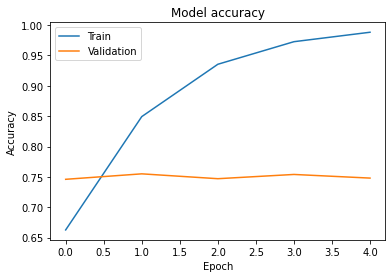

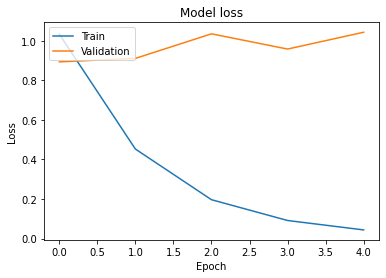

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,4
loss,0.04359
accuracy,0.98814
val_loss,1.04383
val_accuracy,0.748
_runtime,720
_timestamp,1617853395
_step,4
best_val_loss,0.89382
best_epoch,0


epoch,▁▃▅▆█
loss,█▄▂▁▁
accuracy,▁▅▇██
val_loss,▁▂█▄█
val_accuracy,▁█▂▇▃
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: dvc252y4 with config:
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer: 256
wandb: 	pre_layer_train: 20
wandb: 	train_batch_size: 64


model_Xception_aug_True_bs_64_drop_0.2_fc_256_fre_20_epoc_10
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
46554418
Epoch 1/10
140/140 - 217s - loss: 1.1942 - accuracy: 0.6122 - val_loss: 1.0288 - val_accuracy: 0.6980
Epoch 2/10
140/140 - 213s - loss: 0.8343 - accuracy: 0.7256 - val_loss: 0.8248 - val_accuracy: 0.7610
Epoch 3/10
140/140 - 210s - loss: 0.6785 - accuracy: 0.7775 - val_loss: 0.7903 - val_accuracy: 0.7540
Epoch 4/10
140/140 - 210s - loss: 0.5913 - accuracy: 0.7980 - val_loss: 0.8508 - val_accuracy: 0.7520
Epoch 5/10
140/140 - 213s - loss: 0.5113 - accuracy: 0.8273 - val_loss: 0.8456 - val_accuracy: 0.7390
Epoch 6/10
140/140 - 211s - loss: 0.4498 - accuracy: 0.8463 - val_loss: 0.7779 - val_accuracy: 0.7850
Epoch 7/10
140/140 - 211s - loss: 0.3939 - accuracy: 0.8702 - val_loss: 0.9979 - val_accuracy: 0.7430
Epoch 8/10
140/140 - 211s - loss: 0.3358 - accuracy: 0.8851 - val_loss: 0.9416 - val_ac

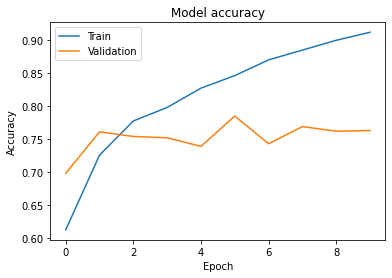

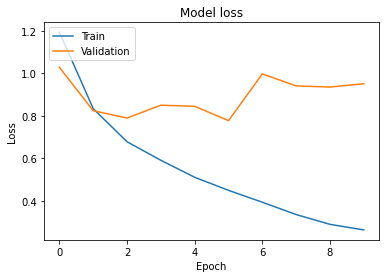

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,9
loss,0.26343
accuracy,0.91214
val_loss,0.95187
val_accuracy,0.763
_runtime,2166
_timestamp,1617855570
_step,9
best_val_loss,0.77792
best_epoch,5


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
accuracy,▁▄▅▅▆▆▇▇██
val_loss,█▂▁▃▃▁▇▆▅▆
val_accuracy,▁▆▆▅▄█▅▇▆▆
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: jotpm881 with config:
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	epochs: 5
wandb: 	fc_layer: 256
wandb: 	pre_layer_train: 20
wandb: 	train_batch_size: 64


model_Xception_aug_False_bs_64_drop_0.1_fc_256_fre_20_epoc_5
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
46554418
Epoch 1/5
140/140 - 130s - loss: 0.9825 - accuracy: 0.6829 - val_loss: 1.3113 - val_accuracy: 0.6970
Epoch 2/5
140/140 - 127s - loss: 0.3851 - accuracy: 0.8741 - val_loss: 0.9088 - val_accuracy: 0.7470
Epoch 3/5
140/140 - 127s - loss: 0.1364 - accuracy: 0.9577 - val_loss: 1.0224 - val_accuracy: 0.7560
Epoch 4/5
140/140 - 127s - loss: 0.0486 - accuracy: 0.9877 - val_loss: 1.2446 - val_accuracy: 0.7360
Epoch 5/5
140/140 - 126s - loss: 0.0296 - accuracy: 0.9922 - val_loss: 1.2564 - val_accuracy: 0.7520


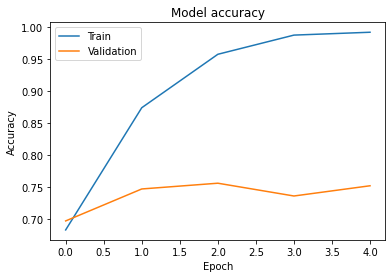

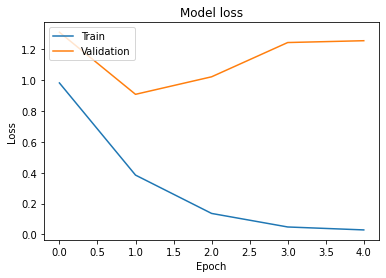

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,4
loss,0.02956
accuracy,0.99217
val_loss,1.25643
val_accuracy,0.752
_runtime,665
_timestamp,1617856242
_step,4
best_val_loss,0.90877
best_epoch,1


epoch,▁▃▅▆█
loss,█▄▂▁▁
accuracy,▁▅▇██
val_loss,█▁▃▇▇
val_accuracy,▁▇█▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: veq2ainh with config:
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	fc_layer: 128
wandb: 	pre_layer_train: 20
wandb: 	train_batch_size: 64


model_Xception_aug_False_bs_64_drop_0.1_fc_128_fre_20_epoc_10
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
33707954
Epoch 1/10
140/140 - 131s - loss: 1.0274 - accuracy: 0.6657 - val_loss: 0.9347 - val_accuracy: 0.7430
Epoch 2/10
140/140 - 126s - loss: 0.4451 - accuracy: 0.8478 - val_loss: 0.9055 - val_accuracy: 0.7480
Epoch 3/10
140/140 - 126s - loss: 0.1777 - accuracy: 0.9438 - val_loss: 1.0099 - val_accuracy: 0.7530
Epoch 4/10
140/140 - 126s - loss: 0.0729 - accuracy: 0.9822 - val_loss: 1.0135 - val_accuracy: 0.7510
Epoch 5/10
140/140 - 126s - loss: 0.0371 - accuracy: 0.9922 - val_loss: 1.1052 - val_accuracy: 0.7580
Epoch 6/10
140/140 - 125s - loss: 0.0254 - accuracy: 0.9943 - val_loss: 1.1495 - val_accuracy: 0.7570
Epoch 7/10
140/140 - 125s - loss: 0.0126 - accuracy: 0.9981 - val_loss: 1.3615 - val_accuracy: 0.7450
Epoch 8/10
140/140 - 125s - loss: 0.0142 - accuracy: 0.9963 - val_loss: 1.2286 - val_a

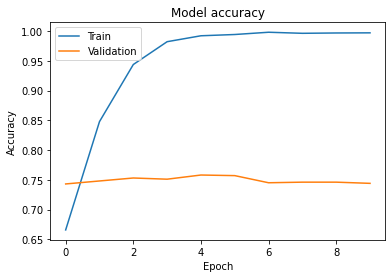

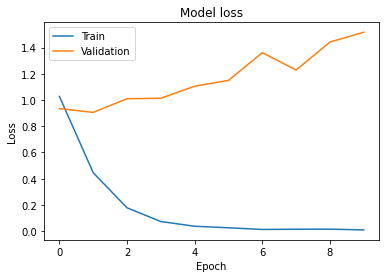

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,9
loss,0.00912
accuracy,0.99709
val_loss,1.51683
val_accuracy,0.744
_runtime,1299
_timestamp,1617857577
_step,9
best_val_loss,0.90555
best_epoch,1


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▁▁▁▁▁▁▁
accuracy,▁▅▇███████
val_loss,▁▁▂▂▃▄▆▅▇█
val_accuracy,▁▃▆▅██▂▂▂▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5yx4y1qh with config:
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer: 512
wandb: 	pre_layer_train: 10
wandb: 	train_batch_size: 64


model_Xception_aug_False_bs_64_drop_0.2_fc_512_fre_10_epoc_10
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
72247346
Epoch 1/10
140/140 - 131s - loss: 1.0070 - accuracy: 0.6771 - val_loss: 1.1707 - val_accuracy: 0.6890
Epoch 2/10
140/140 - 131s - loss: 0.4168 - accuracy: 0.8594 - val_loss: 1.0385 - val_accuracy: 0.7300
Epoch 3/10
140/140 - 129s - loss: 0.1545 - accuracy: 0.9539 - val_loss: 1.0136 - val_accuracy: 0.7570
Epoch 4/10
140/140 - 134s - loss: 0.0573 - accuracy: 0.9852 - val_loss: 1.0598 - val_accuracy: 0.7430
Epoch 5/10
140/140 - 128s - loss: 0.0325 - accuracy: 0.9925 - val_loss: 1.1233 - val_accuracy: 0.7540
Epoch 6/10
140/140 - 128s - loss: 0.0230 - accuracy: 0.9943 - val_loss: 1.2317 - val_accuracy: 0.7620
Epoch 7/10
140/140 - 128s - loss: 0.0168 - accuracy: 0.9966 - val_loss: 1.1508 - val_accuracy: 0.7530
Epoch 8/10
140/140 - 128s - loss: 0.0106 - accuracy: 0.9979 - val_loss: 1.3498 - val_a

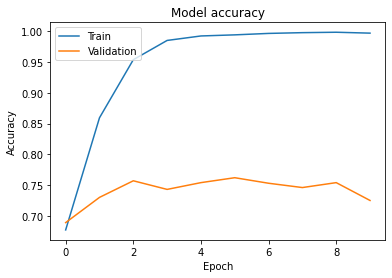

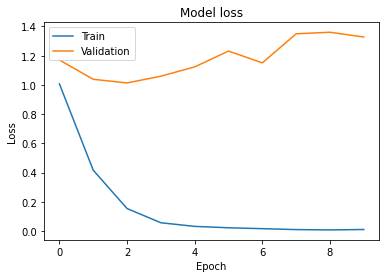

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,9
loss,0.01112
accuracy,0.99709
val_loss,1.32787
val_accuracy,0.725
_runtime,1351
_timestamp,1617858959
_step,9
best_val_loss,1.01364
best_epoch,2


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▁▁▁▁▁▁▁
accuracy,▁▅▇███████
val_loss,▄▂▁▂▃▅▄██▇
val_accuracy,▁▅█▆▇█▇▆▇▄
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: wpt07kw6 with config:
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	fc_layer: 256
wandb: 	pre_layer_train: 20
wandb: 	train_batch_size: 128


model_Xception_aug_True_bs_128_drop_0.1_fc_256_fre_20_epoc_10
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
46554418
Epoch 1/10
70/70 - 222s - loss: 1.2433 - accuracy: 0.5943 - val_loss: 1.0643 - val_accuracy: 0.7040
Epoch 2/10
70/70 - 213s - loss: 0.8297 - accuracy: 0.7260 - val_loss: 0.9056 - val_accuracy: 0.7340
Epoch 3/10
70/70 - 212s - loss: 0.6936 - accuracy: 0.7663 - val_loss: 0.8176 - val_accuracy: 0.7520
Epoch 4/10
70/70 - 211s - loss: 0.5938 - accuracy: 0.8022 - val_loss: 0.8472 - val_accuracy: 0.7550
Epoch 5/10
70/70 - 211s - loss: 0.5055 - accuracy: 0.8255 - val_loss: 0.8898 - val_accuracy: 0.7650
Epoch 6/10
70/70 - 211s - loss: 0.4396 - accuracy: 0.8528 - val_loss: 0.8312 - val_accuracy: 0.7590
Epoch 7/10
70/70 - 212s - loss: 0.3961 - accuracy: 0.8688 - val_loss: 0.9549 - val_accuracy: 0.7590
Epoch 8/10
70/70 - 211s - loss: 0.3298 - accuracy: 0.8874 - val_loss: 0.8778 - val_accuracy: 0.7680


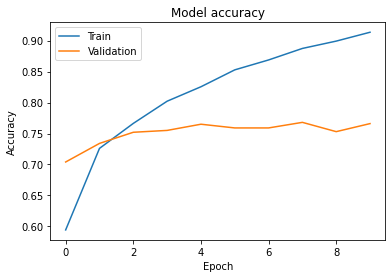

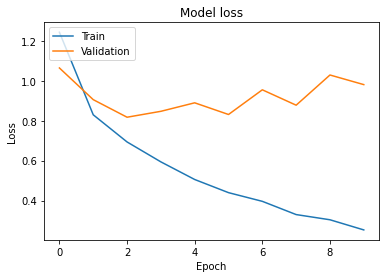

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,9
loss,0.25289
accuracy,0.91354
val_loss,0.98094
val_accuracy,0.766
_runtime,2173
_timestamp,1617861167
_step,9
best_val_loss,0.81755
best_epoch,2


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▃▁▂▃▁▅▃▇▆
val_accuracy,▁▄▆▇█▇▇█▆█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 9r66cxbh with config:
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	epochs: 5
wandb: 	fc_layer: 512
wandb: 	pre_layer_train: 10
wandb: 	train_batch_size: 64


model_Xception_aug_False_bs_64_drop_0.1_fc_512_fre_10_epoc_5
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
72247346
Epoch 1/5
140/140 - 131s - loss: 0.9862 - accuracy: 0.6811 - val_loss: 0.9513 - val_accuracy: 0.7150
Epoch 2/5
140/140 - 126s - loss: 0.3736 - accuracy: 0.8767 - val_loss: 1.0232 - val_accuracy: 0.7390
Epoch 3/5
140/140 - 125s - loss: 0.1297 - accuracy: 0.9599 - val_loss: 0.9473 - val_accuracy: 0.7520
Epoch 4/5
140/140 - 127s - loss: 0.0454 - accuracy: 0.9895 - val_loss: 1.0823 - val_accuracy: 0.7490
Epoch 5/5
140/140 - 126s - loss: 0.0204 - accuracy: 0.9959 - val_loss: 1.1490 - val_accuracy: 0.7540


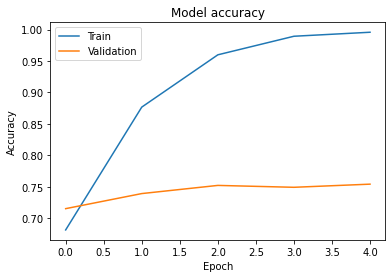

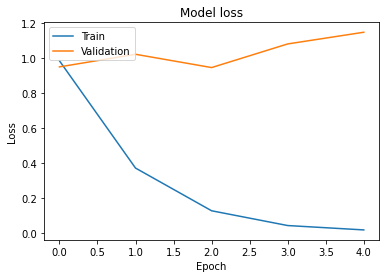

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,4
loss,0.02042
accuracy,0.99586
val_loss,1.14901
val_accuracy,0.754
_runtime,676
_timestamp,1617861868
_step,4
best_val_loss,0.94733
best_epoch,2


epoch,▁▃▅▆█
loss,█▄▂▁▁
accuracy,▁▅▇██
val_loss,▁▄▁▆█
val_accuracy,▁▅█▇█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 1j246sgb with config:
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	epochs: 5
wandb: 	fc_layer: 128
wandb: 	pre_layer_train: None
wandb: 	train_batch_size: 128


model_Xception_aug_False_bs_128_drop_0_fc_128_fre_None_epoc_5
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
33707954
Epoch 1/5
70/70 - 134s - loss: 1.0578 - accuracy: 0.6650 - val_loss: 0.8481 - val_accuracy: 0.7170
Epoch 2/5
70/70 - 125s - loss: 0.5815 - accuracy: 0.8044 - val_loss: 0.8836 - val_accuracy: 0.7260
Epoch 3/5
70/70 - 124s - loss: 0.4114 - accuracy: 0.8686 - val_loss: 0.7898 - val_accuracy: 0.7450
Epoch 4/5
70/70 - 125s - loss: 0.2668 - accuracy: 0.9261 - val_loss: 0.8753 - val_accuracy: 0.7270
Epoch 5/5
70/70 - 125s - loss: 0.1851 - accuracy: 0.9542 - val_loss: 0.8580 - val_accuracy: 0.7500


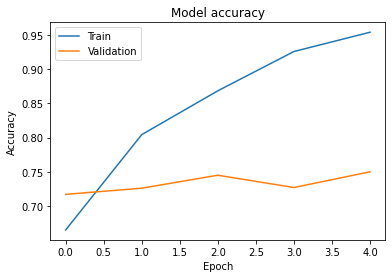

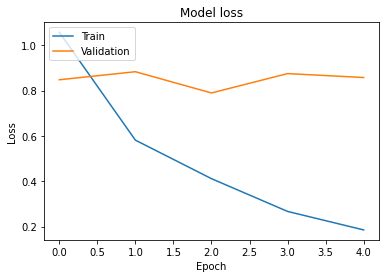

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,4
loss,0.18513
accuracy,0.95423
val_loss,0.85798
val_accuracy,0.75
_runtime,655
_timestamp,1617862562
_step,4
best_val_loss,0.78977
best_epoch,2


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▄▆▇█
val_loss,▅█▁▇▆
val_accuracy,▁▃▇▃█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


In [ ]:
sweep_config = {
  "name": "CS6910 Assignment 2 - Part B",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "data_aug": {
            "values": [True, False]
        },
        "train_batch_size": {
            "values": [64, 128]
        },
        "dropout": {
            "values": [0, 0.2, 0.1]
        },
        "fc_layer": {
            "values": [128, 256, 512]
        },
        "pre_layer_train": {
            "values": [None, 10, 20]
        },
        "epochs":{
            "values": [5,10]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment_2")
wandb.agent(sweep_id, train_validate_model_wandb, count=25)